In [1]:
import pandas as pd
import numpy as np
import random
import datetime

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
from matplotlib.colors import ListedColormap
colors = ['white', '#B7F8FF']
cmap = ListedColormap(colors)

def create_binary_img(df, xlabel=None, ylabel=None, savefig=None):
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(3, 3))

    # Plot the pattern
    cax = ax.matshow(df, cmap=cmap, vmin=0, vmax=1)

    # Set x-axis and y-axis labels
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_xticklabels(df.columns)
    ax.set_yticklabels(df.index)
    # Adjust tick parameters and hide bottom ticks
    ax.tick_params(bottom=False)

    # Add 0/1 labels in each cell
    for i in range(len(df.index)):
        for j in range(len(df.columns)):
            value = df.values[i, j]
            ax.text(j, i, str(value), ha='center', va='center', color='black')

    plt.title(xlabel)
    plt.ylabel(ylabel)

    # Draw vertical grid lines
    for j in range(1, len(df.columns)):
        ax.axvline(j - 0.51, color='#bbb', linewidth=0.1, alpha=1)

    # Draw horizontal grid lines
    for i in range(1, len(df.index)):
        ax.axhline(i - 0.52, color='#bbb', linewidth=0.1, alpha=1)

    plt.tight_layout(pad=0.2)

    if savefig:
        plt.savefig(savefig + ".jpg", dpi=300)

    plt.show()

In [3]:
# Read data
# note that StudentID must be converted to string type. 
# If there are extra rows at the top of the table, set skiprows to skip them
df = pd.read_excel("./example data (simplified).xlsx", skiprows=0)
df["StudentID"] = df["StudentID"].astype(str)
df


,StudentID,CourseID
0,S1,A
1,S1,B
2,S1,C
3,S1,D
4,S1,E
5,S2,B
6,S2,C
7,S2,E
8,S2,F
9,S3,A


In [4]:
# Analyze the number of students per course
lesson_count = df["CourseID"].value_counts().sort_index()
lesson_count

CourseID
A    3
B    3
C    3
D    2
E    2
F    1
G    1
H    1
I    1
J    2
Name: count, dtype: int64

In [5]:
# Count the number of courses per student
student_count = df["StudentID"].value_counts().sort_index()
student_count

StudentID
S1    5
S2    4
S3    3
S4    3
S5    2
S6    2
Name: count, dtype: int64

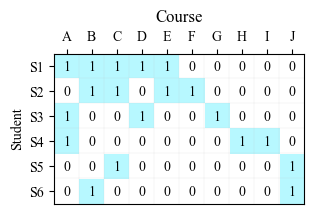

CourseID,A,B,C,D,E,F,G,H,I,J
StudentID,,,,,,,,,,
S1,1,1,1,1,1,0,0,0,0,0
S2,0,1,1,0,1,1,0,0,0,0
S3,1,0,0,1,0,0,1,0,0,0
S4,1,0,0,0,0,0,0,1,1,0
S5,0,0,1,0,0,0,0,0,0,1
S6,0,1,0,0,0,0,0,0,0,1


In [6]:
# Construct a [StudentID-Course] matrix, marking participants with 1
test = pd.DataFrame(0, columns=lesson_count.index, index=student_count.index)
for i, item in df.iterrows():
    test.loc[item["StudentID"], item["CourseID"]] = 1

# test.to_excel("test.xlsx")
create_binary_img(test, xlabel='Course', ylabel='Student', savefig='img/test')
test

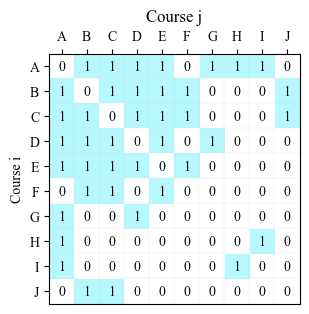

CourseID,A,B,C,D,E,F,G,H,I,J
CourseID,,,,,,,,,,
A,0,1,1,1,1,0,1,1,1,0
B,1,0,1,1,1,1,0,0,0,1
C,1,1,0,1,1,1,0,0,0,1
D,1,1,1,0,1,0,1,0,0,0
E,1,1,1,1,0,1,0,0,0,0
F,0,1,1,0,1,0,0,0,0,0
G,1,0,0,1,0,0,0,0,0,0
H,1,0,0,0,0,0,0,0,1,0
I,1,0,0,0,0,0,0,1,0,0


In [7]:
# Calculate the conflict matrix
contradiction = pd.DataFrame(data=0, columns=lesson_count.index, index=lesson_count.index)
# Mark all conflicting courses
for i, item in test.iterrows():
    # All courses that a student needs to take
    lessons = item[item == 1].index
    # Courses for this student that cannot be taken simultaneously, marked as conflicts with 1
    contradiction.loc[lessons, lessons] = 1

# Courses will not conflict with themselves
for lesson in df["CourseID"].unique():
    contradiction.loc[lesson, lesson] = 0
# contradiction.to_excel("contradiction.xlsx")
create_binary_img(contradiction, xlabel='Course j', ylabel='Course i', savefig='img/contradiction')
contradiction

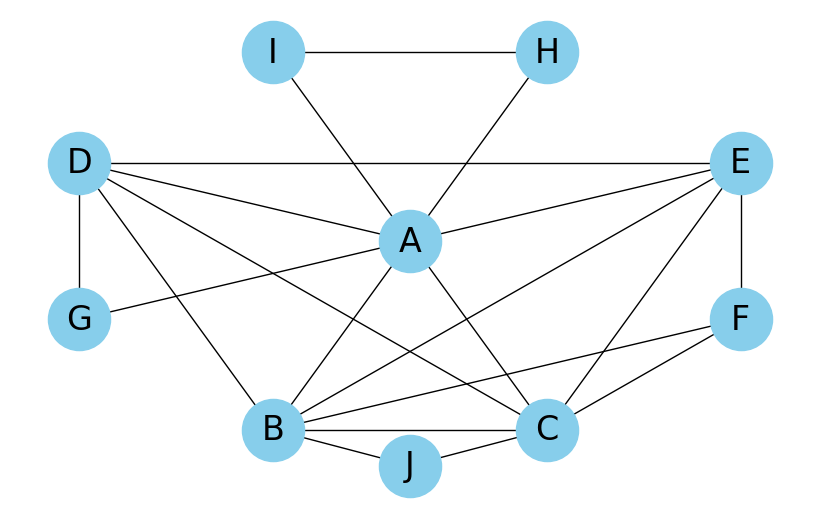

In [8]:
import networkx as nx

# Create an undirected graph object
G = nx.Graph()

# Add nodes to the graph
G.add_nodes_from(contradiction.columns)

# Add edges to the graph
for i in range(len(contradiction.columns)):
    for j in range(i + 1, len(contradiction.columns)):
        if contradiction.iloc[i, j] > 0:
            G.add_edge(contradiction.columns[i], contradiction.columns[j])

# Draw the graph
pos = nx.shell_layout(G, nlist=[['A', 'J'], ['C', 'F', 'E', 'H', 'I', 'D', 'G', 'B']], rotate=(6/8 + 1/16) * np.pi)
pos["A"] = (0, 0)
pos["J"] = (0, -1.1)
plt.figure(figsize=(8, 5), dpi=100)
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=24, node_color='skyblue', font_color='black')
plt.savefig("img/node_graph.svg", format="svg")

In [9]:
nx.to_numpy_array(G, nodelist=sorted(G.nodes()))

array([[0., 1., 1., 1., 1., 0., 1., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 1., 0., 0., 0., 1.],
       [1., 1., 1., 0., 1., 0., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [10]:
from pyqubo import Array, Placeholder, Constraint

In [11]:
# Number of unique courses
n_lesson = len(df["CourseID"].unique())

# Number of batches (e.g., exam slots or periods)
n_batch = 5

# Create a binary array with dimensions (n_lesson, n_batch)
# 'c' indicates a new array, 'BINARY' specifies binary values (0 or 1)
x = Array.create('c', (n_lesson, n_batch), 'BINARY')

In [12]:
# Each course should be scheduled exactly once
constraint1 = 0.0
for i in range(n_lesson):
    # For each course, create a constraint that ensures it is scheduled exactly once
    constraint1 += Constraint((sum(x[i, k] for k in range(n_batch)) - 1)**2, label="threshold1-{}".format(i))

# Conflicting courses cannot be scheduled simultaneously
constraint2 = 0.0
for i in range(n_lesson):
    for j in range(i + 1, n_lesson):
        for k in range(n_batch):
            # Check if courses i and j are in conflict
            if contradiction.iloc[i, j] > 0:
                # Create a constraint to ensure that conflicting courses are not scheduled in the same batch
                constraint2 += Constraint(x[i, k] * x[j, k], label="threshold2-{}_{}_{}".format(i, j, k))

# Initialize profit variable
profit=0.0

In [13]:
# Construct hamiltonian
A = Placeholder("A")
H = profit + A * (constraint1+constraint2)

# Compile model
model = H.compile()

# Generate QUBO
feed_dict = {'A': 1e3}
bqm = model.to_bqm(feed_dict=feed_dict)

In [14]:
# Display the QUBO matrix

# Convert the model to QUBO format and get the offset
qubo, offset = model.to_qubo(feed_dict=feed_dict)
print("Number of terms in polynomial:", len(qubo), ", Offset:", offset)

# Extract all unique variables from the QUBO dictionary
variables = set()
for var_pair in qubo.keys():
    variables.update(var_pair)

# Create a mapping from variables to indices
variable_to_index = {var: index for index, var in enumerate(variables)}

# Determine the size of the matrix based on the number of unique variables
max_index = len(variables)

# Create an empty matrix to hold the QUBO coefficients
qubo_matrix = np.zeros((max_index, max_index))

# Map QUBO terms to the matrix
for (var1, var2), value in qubo.items():
    index1 = variable_to_index[var1]
    index2 = variable_to_index[var2]
    qubo_matrix[index1, index2] = value
    qubo_matrix[index2, index1] = value  # Ensure the matrix is symmetric

# Output the shape of the QUBO matrix
qubo_matrix.shape

Number of terms in polynomial: 250 , Offset: 10000.0


(50, 50)

In [15]:
import neal
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=50, num_sweeps=10000)

# Decode solution
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
best_sample = min(decoded_samples, key=lambda x: x.energy)
num_violated = len(best_sample.constraints(only_broken=True))
print("number of violated constraint = {}".format(num_violated))
print("violated constraints: ",best_sample.constraints(only_broken=True))
print("energy: ",best_sample.energy)

# Print the best sample's binary vector
print(best_sample.sample)

number of violated constraint = 0
violated constraints:  {}
energy:  0.0
{'c[9][3]': 0, 'c[3][1]': 0, 'c[0][0]': 0, 'c[7][4]': 0, 'c[1][2]': 0, 'c[9][2]': 0, 'c[3][0]': 1, 'c[0][1]': 0, 'c[1][1]': 0, 'c[9][1]': 1, 'c[3][3]': 0, 'c[0][2]': 0, 'c[1][0]': 0, 'c[9][0]': 0, 'c[3][2]': 0, 'c[0][3]': 0, 'c[0][4]': 1, 'c[4][4]': 0, 'c[1][3]': 1, 'c[7][2]': 1, 'c[4][3]': 0, 'c[1][4]': 0, 'c[6][4]': 0, 'c[2][0]': 0, 'c[2][1]': 0, 'c[2][2]': 1, 'c[2][3]': 0, 'c[6][0]': 0, 'c[2][4]': 0, 'c[3][4]': 0, 'c[7][1]': 0, 'c[4][0]': 0, 'c[7][0]': 0, 'c[4][1]': 1, 'c[7][3]': 0, 'c[4][2]': 0, 'c[5][0]': 1, 'c[5][1]': 0, 'c[5][2]': 0, 'c[5][3]': 0, 'c[5][4]': 0, 'c[6][1]': 0, 'c[6][2]': 1, 'c[6][3]': 0, 'c[8][0]': 0, 'c[8][1]': 0, 'c[8][2]': 0, 'c[8][3]': 1, 'c[8][4]': 0, 'c[9][4]': 0}


In [16]:
import minorminer

# Solve using pure quantum computation
if len(qubo_matrix) <= 500:  # Difficult to run if the matrix size exceeds 500
    from dwave.system import DWaveSampler, EmbeddingComposite
    from dwave.embedding.chain_breaks import majority_vote, weighted_random

    # Initialize the D-Wave sampler with embedding capabilities
    sa = EmbeddingComposite(DWaveSampler(
        token="",  # Provide your D-Wave token here
        solver={"qpu": True},
        # Uncomment and specify a solver if necessary
        # solver="Advantage2_prototype1.1",
        # solver="Advantage2_prototype2.3",
        # solver="Advantage_system4.1",
        # solver="Advantage_system6.4",
    ), find_embedding=minorminer.find_embedding, embedding_parameters={'timeout': 10})

    # Sample from the BQM using the D-Wave sampler
    sampleset = sa.sample(bqm, label='Exam Schedule DWaveSampler', num_reads=500, annealing_time=200, chain_break_method=majority_vote)
    
    # Decode the sampled solutions
    decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
    # Select the best sample based on energy
    best_sample = min(decoded_samples, key=lambda x: x.energy)
    # Count the number of broken constraints
    num_broken = len(best_sample.constraints(only_broken=True))
    
    print("Number of unsatisfied constraints: {}".format(num_broken))
    print("Unsatisfied constraints:", best_sample.constraints(only_broken=True))
    print("Total score:", best_sample.energy)
    
    # Print the best sample's binary vector
    print(best_sample.sample)


Number of unsatisfied constraints: 0
Unsatisfied constraints: {}
Total score: 0.0
{'c[9][3]': 0, 'c[3][1]': 1, 'c[0][0]': 0, 'c[7][4]': 0, 'c[1][2]': 0, 'c[9][2]': 0, 'c[3][0]': 0, 'c[0][1]': 0, 'c[1][1]': 0, 'c[9][1]': 0, 'c[3][3]': 0, 'c[0][2]': 0, 'c[1][0]': 0, 'c[9][0]': 1, 'c[3][2]': 0, 'c[0][3]': 0, 'c[0][4]': 1, 'c[4][4]': 0, 'c[1][3]': 1, 'c[7][2]': 0, 'c[4][3]': 0, 'c[1][4]': 0, 'c[6][4]': 0, 'c[2][0]': 0, 'c[2][1]': 0, 'c[2][2]': 1, 'c[2][3]': 0, 'c[6][0]': 0, 'c[2][4]': 0, 'c[3][4]': 0, 'c[7][1]': 0, 'c[4][0]': 1, 'c[7][0]': 0, 'c[4][1]': 0, 'c[7][3]': 1, 'c[4][2]': 0, 'c[5][0]': 0, 'c[5][1]': 0, 'c[5][2]': 0, 'c[5][3]': 0, 'c[5][4]': 1, 'c[6][1]': 0, 'c[6][2]': 1, 'c[6][3]': 0, 'c[8][0]': 0, 'c[8][1]': 1, 'c[8][2]': 0, 'c[8][3]': 0, 'c[8][4]': 0, 'c[9][4]': 0}


In [17]:
# Hybrid solver approach
from dwave.system import LeapHybridSampler

# Initialize the Leap Hybrid Sampler with your D-Wave token
sa = LeapHybridSampler(token="")

# Sample from the BQM using the Leap Hybrid Sampler
# The time_limit specifies the maximum time in seconds for solving the problem
sampleset = sa.sample(bqm, label='Exam Schedule LeapHybridSampler',time_limit=None)

# Decode the solutions from the sampleset
decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)

# Select the best sample based on energy
best_sample = min(decoded_samples, key=lambda x: x.energy)

# Count the number of violated constraints in the best sample
num_violated = len(best_sample.constraints(only_broken=True))

print("Number of violated constraints = {}".format(num_violated))
print("Violated constraints: ", best_sample.constraints(only_broken=True))
print("Energy: ", best_sample.energy)

# Print the best sample's binary vector
print(best_sample.sample)

Number of violated constraints = 0
Violated constraints:  {}
Energy:  0.0
{'c[9][3]': 0, 'c[3][1]': 0, 'c[0][0]': 0, 'c[7][4]': 1, 'c[1][2]': 0, 'c[9][2]': 0, 'c[3][0]': 0, 'c[0][1]': 0, 'c[1][1]': 0, 'c[9][1]': 1, 'c[3][3]': 0, 'c[0][2]': 1, 'c[1][0]': 0, 'c[9][0]': 0, 'c[3][2]': 0, 'c[0][3]': 0, 'c[0][4]': 0, 'c[4][4]': 0, 'c[1][3]': 1, 'c[7][2]': 0, 'c[4][3]': 0, 'c[1][4]': 0, 'c[6][4]': 0, 'c[2][0]': 1, 'c[2][1]': 0, 'c[2][2]': 0, 'c[2][3]': 0, 'c[6][0]': 1, 'c[2][4]': 0, 'c[3][4]': 1, 'c[7][1]': 0, 'c[4][0]': 0, 'c[7][0]': 0, 'c[4][1]': 1, 'c[7][3]': 0, 'c[4][2]': 0, 'c[5][0]': 0, 'c[5][1]': 0, 'c[5][2]': 0, 'c[5][3]': 0, 'c[5][4]': 1, 'c[6][1]': 0, 'c[6][2]': 0, 'c[6][3]': 0, 'c[8][0]': 0, 'c[8][1]': 1, 'c[8][2]': 0, 'c[8][3]': 0, 'c[8][4]': 0, 'c[9][4]': 0}


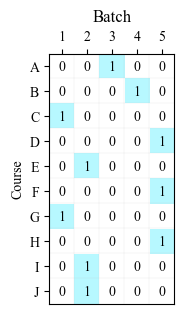

,1,2,3,4,5
CourseID,,,,,
A,0,0,1,0,0
B,0,0,0,1,0
C,1,0,0,0,0
D,0,0,0,0,1
E,0,1,0,0,0
F,0,0,0,0,1
G,1,0,0,0,0
H,0,0,0,0,1
I,0,1,0,0,0


In [18]:
# Exam scheduling matrix solution (columns represent batches; rows represent courses)
plan = pd.DataFrame(0, index=lesson_count.index, columns=np.arange(n_batch) + 1)

# Populate the schedule matrix based on the best sample
for i in range(n_lesson):
    for k in range(n_batch):
        # Check if the variable corresponding to course i and batch k is set to 1
        if best_sample.sample['c[%d][%d]' % (i, k)] == 1:
            # Mark the presence of the course in the specified batch
            plan.iloc[i, k] = 1

# Optionally save the schedule matrix to an Excel file
# plan.to_excel("plan.xlsx")

# Create a binary image representation of the scheduling matrix
create_binary_img(plan, xlabel='Batch', ylabel='Course', savefig='img/plan')

# Display the scheduling matrix
plan

In [19]:
# Calculate the number of subjects scheduled in each batch
number_of_subjects_per_batch = plan.sum()
number_of_subjects_per_batch

1    2
2    3
3    1
4    1
5    3
dtype: int64

In [20]:
# Convert to a Student-Batch matrix
Splan = pd.DataFrame("-", columns=np.arange(n_batch) + 1, index=test.index)

# Populate the Student-Batch matrix
for lesson in plan.index:
    for batch in plan.columns:
        if plan.loc[lesson, batch] > 0:
            # Find all students scheduled for this course
            student_ids = test[test[lesson] == 1].index
            # Mark these students as having this course in the specified batch
            Splan.loc[student_ids, batch] = lesson

# Save the Student-Batch matrix to an Excel file
# Splan.to_excel("Splan.xlsx")

# Display the Student-Batch matrix
Splan

,1,2,3,4,5
StudentID,,,,,
S1,C,E,A,B,D
S2,C,E,-,B,F
S3,G,-,A,-,D
S4,-,I,A,-,H
S5,C,J,-,-,-
S6,-,J,-,B,-


In [21]:
# Count the number of students per batch
student_counts_per_batch = Splan.applymap(lambda x: None if x == "-" else x).count()

# Display the counts
student_counts_per_batch

1    4
2    5
3    3
4    3
5    4
dtype: int64